In [1]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
import torchvision

from mupify import mupify

import matplotlib.pyplot as plt

plt.rc("figure", dpi=100, facecolor=(1, 1, 1))
plt.rc("font", family='stixgeneral', size=14)
plt.rc("axes", facecolor=(1, .99, .95), titlesize=18)
plt.rc("mathtext", fontset='cm')
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=
       r"""\usepackage{bm}
       \usepackage{physics}""")

In [2]:
class ImageData():

    dataset_dict = {
        'mnist': torchvision.datasets.MNIST,
        'fmnist': torchvision.datasets.FashionMNIST,
        'cifar10': torchvision.datasets.CIFAR10,
        'cifar100': torchvision.datasets.CIFAR100
    }

    def __init__(self, dataset_name, data_dir):

        assert dataset_name in self.dataset_dict
        self.name = dataset_name

        def format_data(dataset):
            if self.name in ['cifar10','cifar100']:
                X, y = dataset.data, dataset.targets
                X = X.transpose(0, 3, 1, 2)
            if self.name in ['mnist', 'fmnist']:
                X, y = dataset.data.numpy(), dataset.targets.numpy()
                X = X[:, None, :,:]
            X = X/255.0                
            y = F.one_hot(torch.Tensor(y).long()).numpy()
            return X.astype(np.float32), y.astype(np.float32)
        
        raw_train = self.dataset_dict[self.name](root=data_dir, train=True, download=True)
        raw_test = self.dataset_dict[self.name](root=data_dir, train=False, download=True)

        # process raw datasets
        self.train_X, self.train_y = format_data(raw_train)
        self.test_X, self.test_y = format_data(raw_test)

    def get_dataset(self, n, get="train"):
        n = int(n)
        assert n > 0
        assert get in ["train", "test"]
        full_X, full_y = (self.train_X, self.train_y) if get == "train" else (self.test_X, self.test_y)
        X, y = full_X[:n].copy(), full_y[:n].copy()
        return X, y


In [3]:
def test_error(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            d_out = output.shape[1]
            test_loss += F.mse_loss(output, target, reduction='sum').item() / d_out
            pred = output.argmax(dim=1)
            correct += (pred==target.argmax(dim=1)).sum().item()
    test_loss /= len(test_loader.dataset)
    accuracy = correct / len(test_loader.dataset)
    return test_loss, accuracy

In [4]:
def print_model_measurements(model, optimizer, input):
    print("== Output scale ==")
    print(f"{model(input).std().item():.4f}")
    print()

    print("== Init weight scale ==")
    for k, v in model.named_modules():
        if not hasattr(v, 'weight'):
            continue
        print(f"{k:<20} {v.weight.std().item():.4f}")
    print()

    print("== Layerwise learning rates ==")
    for name, param in model.named_parameters():
        if 'bias' in name:
            continue
        name = name[:-7]
        for pg in optimizer.param_groups:
            if id(param) in [id(p) for p in pg['params']]:
                print(f"{name:<20} {pg['lr']:.4f}")

# Tutorial: MLP @ MNIST

In [5]:
class SimpleMLP(nn.Module):
    
    def __init__(self, d_in, d_out, width):
        super().__init__()
        self.fc1 = nn.Linear(d_in, width)
        self.fc2 = nn.Linear(width, width)
        self.fc3 = nn.Linear(width, d_out)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
param = 'mup-lr'    # choose one of ["ntp", "mup", "mfp", "ntp-lr", "mup-lr"].

model = SimpleMLP(d_in=784, d_out=10, width=512).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=1, momentum=0.9)
mupify(model, optimizer, param=param, verbose=True)

inp = torch.normal(0, 1, size=(256, 784)).cuda()
print_model_measurements(model, optimizer, inp)

== Model anatomy ==
d_in = 784
d_out = 10
widths: [512, 512]
	 using width = 512
readin layer: fc1
readout layer: fc3

== Output scale ==
0.0408

== Init weight scale ==
fc1                  0.0358
fc2                  0.0441
fc3                  0.0020

== Layerwise learning rates ==
fc1                  0.6531
fc2                  1.0000
fc3                  0.0020


In [7]:
imdata = ImageData("mnist", 'data')
X_train, y_train = imdata.get_dataset(5000, get='train')
X_test, y_test = imdata.get_dataset(5000, get='test')
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
X_train, y_train, X_test, y_test = [torch.Tensor(d).cuda() for d in (X_train, y_train, X_test, y_test)]

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train, y_train),
                                           batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_test, y_test),
                                          batch_size=64, shuffle=False)

In [8]:
ntrials = 3
nepochs = 15
test_errors = np.empty((5, ntrials, nepochs))

for i, param in enumerate(["ntp", "ntp-lr", "mup", "mup-lr", "mfp"]):
    for trial in range(ntrials):
        model = SimpleMLP(d_in=784, d_out=10, width=512).to(device)
        optimizer = torch.optim.SGD(model.parameters(), lr=1, momentum=0.9)
        mupify(model, optimizer, param=param)
        for epoch in range(nepochs):
            print('.', end='')
            test_loss, accuracy = test_error(model, test_loader)
            test_errors[i, trial, epoch] = test_loss
            for batch_idx, (data, target) in enumerate(train_loader):
                optimizer.zero_grad()
                output = model(data)
                loss = F.mse_loss(output, target)
                loss.backward()
                optimizer.step()
    print()


.............................................
.............................................
.............................................
.............................................
.............................................


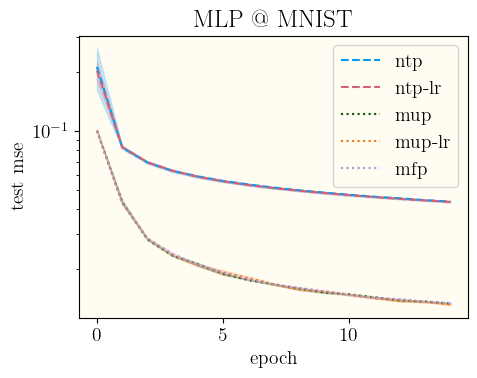

In [9]:
plt.figure(figsize=(5, 4))

labels = ["ntp", "ntp-lr", "mup", "mup-lr", "mfp"]
colors = ['xkcd:azure', 'xkcd:rose', 'xkcd:forest', 'xkcd:orange', 'xkcd:pale purple']
ls = ["--", "--", ":", ":", ":"]
for i, label in enumerate(labels):
    acc = test_errors[i]
    mean, std = acc.mean(axis=0), acc.std(axis=0)
    epochs = np.arange(len(mean))
    plt.plot(epochs, mean, color=colors[i], label=label, ls=ls[i])
    plt.fill_between(epochs, mean-std, mean+std, alpha=0.2, color=colors[i])

plt.title('MLP @ MNIST')
plt.legend()
plt.yscale('log')
plt.ylabel('test mse')
plt.xlabel('epoch')
plt.tight_layout()
plt.show()

# Scaling experiments

In [11]:
class SimpleMLP(nn.Module):
    
    def __init__(self, d_in, d_out, width):
        super().__init__()
        self.fc1 = nn.Linear(d_in, width)
        self.fc2 = nn.Linear(width, width)
        self.fc3 = nn.Linear(width, d_out)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def get_activations(self, x):
        h1 = self.relu(self.fc1(x))
        h2 = self.relu(self.fc2(h1))
        h3 = self.fc3(h2)
        return h1, h2, h3
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
imdata = ImageData("mnist", 'data')
X_train, y_train = imdata.get_dataset(5000, get='train')
X_test, y_test = imdata.get_dataset(5000, get='test')
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
X_train, y_train, X_test, y_test = [torch.Tensor(d).cuda() for d in (X_train, y_train, X_test, y_test)]

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train, y_train),
                                           batch_size=512, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_test, y_test),
                                          batch_size=512, shuffle=False)

In [62]:
ntrials = 100
widths = np.logspace(8, 12, num=10, base=2).astype(int)
update_sizes = np.empty((2, len(widths), ntrials))

for i, param in enumerate(["ntp", "mup"]):
    for j, width in enumerate(widths):
        print('.', end='')
        model = SimpleMLP(d_in=784, d_out=10, width=width).to(device)
        for trial in range(ntrials):
            optimizer = torch.optim.SGD(model.parameters(), lr=1, momentum=0.9)
            mupify(model, optimizer, param=param)
            
            data, target = next(iter(train_loader))
            optimizer.zero_grad()
            _, h2, h3 = model.get_activations(data)
            loss = F.mse_loss(h3, target)
            loss.backward()
            optimizer.step()
            _, h2_new, _ = model.get_activations(data)
            
            update_size = torch.linalg.norm(h2_new - h2) / torch.linalg.norm(h2)
            update_sizes[i, j, trial] = update_size        
    print()


..........
..........


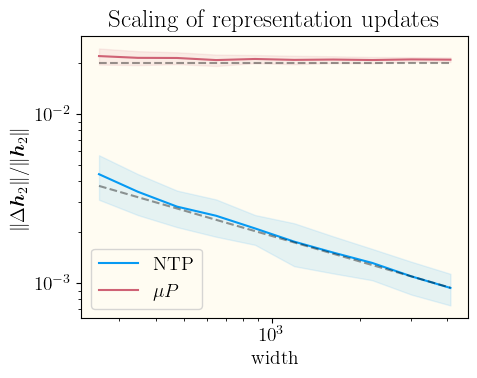

In [69]:
plt.figure(figsize=(5, 4))

labels = ["NTP", r"$\mu P$"]
colors = ['xkcd:azure', 'xkcd:rose']
for i, label in enumerate(labels):
    update_sz = update_sizes[i].mean(axis=1)
    update_std = update_sizes[i].std(axis=1)
    plt.plot(widths, update_sz, color=colors[i], label=label)
    plt.fill_between(widths, update_sz-update_std, update_sz+update_std, color=colors[i], alpha=0.1)
plt.plot(widths, 0.06*widths**(-0.5), alpha=0.4, color='k', ls='--')
plt.plot(widths, 0.02*widths**0, alpha=0.4, color='k', ls='--')

plt.title('Scaling of representation updates')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$\norm{\Delta \bm{h}_2}/\norm{\bm{h}_2}$')
plt.xlabel('width')
plt.tight_layout()
plt.show()

# Hyperparameter transfer

In [119]:
class SimpleMLP(nn.Module):
    
    def __init__(self, d_in, d_out, width):
        super().__init__()
        self.fc1 = nn.Linear(d_in, width)
        self.fc2 = nn.Linear(width, width)
        self.fc3 = nn.Linear(width, d_out)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [138]:
imdata = ImageData("mnist", 'data')
X_train, y_train = imdata.get_dataset(2000, get='train')
X_test, y_test = imdata.get_dataset(5000, get='test')
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
X_train, y_train, X_test, y_test = [torch.Tensor(d).cuda() for d in (X_train, y_train, X_test, y_test)]

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train, y_train),
                                           batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_test, y_test),
                                          batch_size=64, shuffle=False)

In [141]:
ntrials = 5
widths = np.logspace(5, 9, num=5, base=2).astype(int)
mup_lrs = np.logspace(1, 6, num=30, base=2)
ntp_lrs = np.logspace(3, 8, num=30, base=2)
test_errors = np.empty((2, len(widths), len(mup_lrs), ntrials))

for i, param in enumerate(["ntp", "mup"]):
    lrs = mup_lrs if param=="mup" else ntp_lrs
    for j, width in enumerate(widths):
        for k, lr in enumerate(lrs):
            print('.', end='')
            model = SimpleMLP(d_in=784, d_out=10, width=width).to(device)
            for trial in range(ntrials):
                optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
                mupify(model, optimizer, param=param)
                for epoch in range(1):                    
                    for data, target in train_loader:
                        optimizer.zero_grad()
                        output = model(data)
                        loss = F.mse_loss(output, target)
                        loss.backward()
                        optimizer.step()
                test_loss, accuracy = test_error(model, test_loader)
                if not test_loss < 1e5:
                    test_loss = 1e5
                test_errors[i, j, k, trial] = test_loss
        print()


..............................
..............................
..............................
..............................
..............................
..............................
..............................
..............................
..............................
..............................


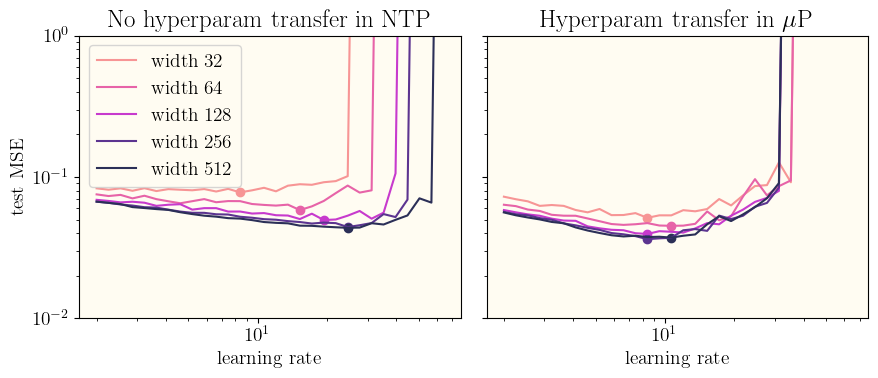

In [157]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(9, 4))

titles = ["No hyperparam transfer in NTP", r"Hyperparam transfer in $\mu$P"]
colors = "#2b2f57 #5c3490 #c73acd #e763a8 #f79595".split(' ')[::-1]
for i, title in enumerate(titles):
    axes[i].set_title(title)
    axes[i].set_xscale('log')
    axes[i].set_yscale('log')
    axes[i].set_ylim(1e-2, 1e0)
    axes[i].set_xlabel('learning rate')
    lrs = ntp_lrs if label=="NTP" else mup_lrs
    for j, width in enumerate(widths):
        test_err = test_errors[i, j].mean(axis=1)
        test_err[np.argwhere(test_err>1e1)[0, 0]:] = 1e5
        axes[i].plot(lrs, test_err, color=colors[j], label=f'width {width}')
        min_lr = lrs[np.argmin(test_err)]
        axes[i].scatter(min_lr, min(test_err), color=colors[j])


axes[0].legend()
axes[0].set_ylabel('test MSE')

plt.tight_layout()
plt.show()

# Tutorial: CNN @ CIFAR10

In [106]:
class Myrtle5(nn.Module):
    
    def __init__(self, chan_in=3, d_out=10, width=512):
        super().__init__()
        ksz = 3
        self.conv1 = nn.Conv2d(chan_in, width, ksz, padding='same')
        self.conv2 = nn.Conv2d(width, width, ksz, padding='same')
        self.conv3 = nn.Conv2d(width, width, ksz, padding='same')
        self.conv4 = nn.Conv2d(width, width, ksz, padding='same')
        self.readout = nn.Linear(width, d_out)
        self.pool = nn.AvgPool2d(kernel_size=2)
        self.gap = nn.AvgPool2d(kernel_size=8)
        self.relu = nn.ReLU()

    def forward(self, x):
        h1 = self.relu(self.conv1(x))
        h2 = self.pool(self.relu(self.conv2(h1)))
        h3 = self.pool(self.relu(self.conv3(h2)))
        h4 = self.gap(self.relu(self.conv4(h3)))
        return self.readout(h4.squeeze())

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [107]:
param = 'mup'    # choose one of ["ntp", "mup", "mfp", "ntp-lr", "mup-lr"].

model = Myrtle5(chan_in=3, d_out=10, width=512).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=1, momentum=0.9)
mupify(model, optimizer, param=param, verbose=True)

inp = torch.normal(0, 1, size=(256, 3, 32, 32)).cuda()
print_model_measurements(model, optimizer, inp)

== Model anatomy ==
d_in = 3
d_out = 10
widths: [512, 512, 512, 512]
	 using width = 512
readin layer: conv1
readout layer: readout

== Output scale ==
0.0208

== Init weight scale ==
conv1                0.0441
conv2                0.0442
conv3                0.0442
conv4                0.0442
readout              0.0439

== Layerwise learning rates ==
conv1                1.0000
conv2                1.0000
conv3                1.0000
conv4                1.0000
readout              1.0000


In [108]:
imdata = ImageData("cifar10", 'data')
X_train, y_train = imdata.get_dataset(10000, get='train')
X_test, y_test = imdata.get_dataset(5000, get='test')
X_train, y_train, X_test, y_test = [torch.Tensor(d).cuda() for d in (X_train, y_train, X_test, y_test)]

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train, y_train),
                                           batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_test, y_test),
                                          batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [18]:
ntrials = 3
nepochs = 15
test_errors = np.empty((5, ntrials, nepochs))

for i, param in enumerate(["ntp", "ntp-lr", "mup", "mup-lr", "mfp"]):
    for trial in range(ntrials):
        model = Myrtle5(chan_in=3, d_out=10, width=128).to(device)
        optimizer = torch.optim.SGD(model.parameters(), lr=1, momentum=0.9)
        mupify(model, optimizer, param=param)
        for epoch in range(nepochs):
            print('.', end='')
            test_loss, accuracy = test_error(model, test_loader)
            test_errors[i, trial, epoch] = test_loss
            for batch_idx, (data, target) in enumerate(train_loader):
                optimizer.zero_grad()
                output = model(data)
                loss = F.mse_loss(output, target)
                loss.backward()
                optimizer.step()
    print()

.............................................
.............................................
.............................................
.............................................
.............................................


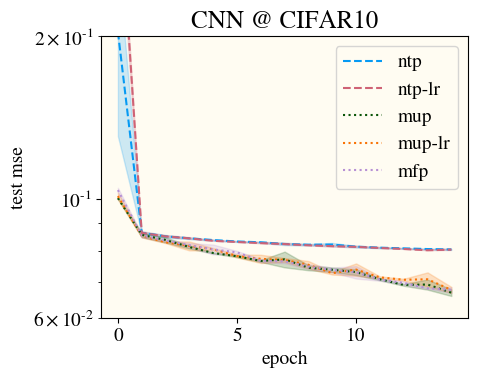

In [22]:
plt.figure(figsize=(5, 4))

labels = ["ntp", "ntp-lr", "mup", "mup-lr", "mfp"]
colors = ['xkcd:azure', 'xkcd:rose', 'xkcd:forest', 'xkcd:orange', 'xkcd:pale purple']
ls = ["--", "--", ":", ":", ":"]
for i, label in enumerate(labels):
    acc = test_errors[i]
    mean, std = acc.mean(axis=0), acc.std(axis=0)
    epochs = np.arange(len(mean))
    plt.plot(epochs, mean, color=colors[i], label=label, ls=ls[i])
    plt.fill_between(epochs, mean-std, mean+std, alpha=0.2, color=colors[i])

plt.title('CNN @ CIFAR10')
plt.legend()
plt.yscale('log')
plt.ylabel('test mse')
plt.ylim(top=0.2)
plt.xlabel('epoch')
plt.tight_layout()
plt.show()

# Myrtle Mixer

In [109]:
class MyrtleMixer5(nn.Module):
    
    def __init__(self, chan_in=3, d_out=10, width=512):
        super().__init__()
        ksz = 5
        self.conv1 = nn.Conv2d(chan_in, width, ksz, padding='same')
        self.conv2 = nn.Conv2d(width, width, ksz, groups=width, padding='same')
        self.mlp2 = nn.Conv2d(width, width, 1, padding='same')
        self.conv3 = nn.Conv2d(width, width, ksz, groups=width, padding='same')
        self.mlp3 = nn.Conv2d(width, width, 1, padding='same')
        self.conv4 = nn.Conv2d(width, width, ksz, groups=width, padding='same')
        self.mlp4 = nn.Conv2d(width, width, 1, padding='same')
        self.readout = nn.Linear(width, d_out)
        self.pool = nn.AvgPool2d(kernel_size=2)
        self.gap = nn.AvgPool2d(kernel_size=8)
        self.relu = nn.ReLU()

    def forward(self, x):
        h1 = self.relu(self.conv1(x))
        h2 = self.pool(self.relu(self.mlp2(self.conv2(h1))))
        h3 = self.pool(self.relu(self.mlp3(self.conv3(h2))))
        h4 = self.gap(self.relu(self.mlp4(self.conv4(h3))))
        return self.readout(h4.squeeze())

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [110]:
param = 'ntp-lr'

model = MyrtleMixer5(chan_in=3, d_out=10, width=512).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=1, momentum=0.9)
mupify(model, optimizer, param=param, verbose=True)

inp = torch.normal(0, 1, size=(256, 3, 32, 32)).cuda()
print_model_measurements(model, optimizer, inp)

== Model anatomy ==
d_in = 3
d_out = 10
widths: [512, 512, 512, 512, 512, 512, 512]
	 using width = 512
readin layer: conv1
readout layer: readout

== Output scale ==
0.3362

== Init weight scale ==
conv1                0.1150
conv2                0.1994
mlp2                 0.0441
conv3                0.2011
mlp3                 0.0442
conv4                0.2001
mlp4                 0.0441
readout              0.0437

== Layerwise learning rates ==
conv1                0.0133
conv2                0.0400
mlp2                 0.0020
conv3                0.0400
mlp3                 0.0020
conv4                0.0400
mlp4                 0.0020
readout              0.0020


In [111]:
imdata = ImageData("cifar10", 'data')
X_train, y_train = imdata.get_dataset(10000, get='train')
X_test, y_test = imdata.get_dataset(5000, get='test')
X_train, y_train, X_test, y_test = [torch.Tensor(d).cuda() for d in (X_train, y_train, X_test, y_test)]

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train, y_train),
                                           batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_test, y_test),
                                          batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [115]:
WIDTH = 128
ntrials = 3
nepochs = 15
test_errors = np.empty((2, ntrials, nepochs))

for i, param in enumerate(["ntp", "mup"]):
    for trial in range(ntrials):
        model = MyrtleMixer5(chan_in=3, d_out=10, width=WIDTH).to(device)
        optimizer = torch.optim.SGD(model.parameters(), lr=1, momentum=0.9)
        mupify(model, optimizer, param=param)
        for epoch in range(nepochs):
            print('.', end='')
            test_loss, accuracy = test_error(model, test_loader)
            test_errors[i, trial, epoch] = test_loss
            for batch_idx, (data, target) in enumerate(train_loader):
                optimizer.zero_grad()
                output = model(data)
                loss = F.mse_loss(output, target)
                loss.backward()
                optimizer.step()
    print()

.............................................
.............................................


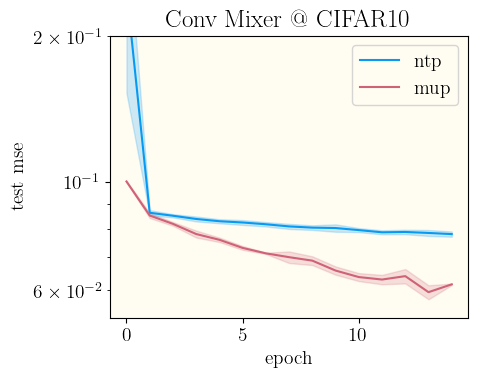

In [116]:
plt.figure(figsize=(5, 4))

labels = ["ntp", "mup"]
colors = ['xkcd:azure', 'xkcd:rose']
for i, label in enumerate(labels):
    acc = test_errors[i]
    mean, std = acc.mean(axis=0), acc.std(axis=0)
    epochs = np.arange(len(mean))
    plt.plot(epochs, mean, color=colors[i], label=label)
    plt.fill_between(epochs, mean-std, mean+std, alpha=0.2, color=colors[i])

plt.title('Conv Mixer @ CIFAR10')
plt.legend()
plt.yscale('log')
plt.ylabel('test mse')
plt.ylim(top=0.2)
plt.xlabel('epoch')
plt.tight_layout()
plt.show()